In [1]:
import torchvision

from torch import Tensor, cuda
from src.plots import plot_vae_classifier_training_result, plot_image_label

from src.vae.cifar_vae import VaeAutoencoderClassifier
from src.image_classifier.image_classifier import CIFAR10Classifier
from src.utils import frechet_inception_distance

In [2]:
# convert data to a normalized torch.FloatTensor
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

training_data = torchvision.datasets.CIFAR10(root='../data/CIFAR10_train', train=True, download=True, transform=transform)
testing_data = torchvision.datasets.CIFAR10(root='../data/CIFAR10_test', train=False, download=True, transform=transform)

print(training_data)
print(testing_data)

input = training_data.data[:50000]
labels = training_data.targets[:50000]

Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../data/CIFAR10_train
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ../data/CIFAR10_test
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


In [3]:
# Train VAE
vae = VaeAutoencoderClassifier(channel_num=3, kernel_num=128, dim_encoding=100)

print("Reached here")

# works best for around alpha of 10000 and 20 epochs
vae_classifier_model, total_losses, classifier_accuracy_li, classifier_loss_li, vae_loss_li, kl_loss_li = vae.train_model(
    training_data=training_data,
    batch_size=64,
    alpha=1,
    beta=1,
    epochs=20
)

Reached here


/home/neo/projects/Federated-Learning-PyTorch/venv/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


RuntimeError: The size of tensor a (100) must match the size of tensor b (28) at non-singleton dimension 1

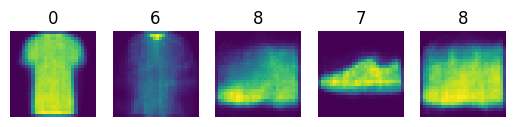

In [4]:
# plot generated data
image_tensor, label_tensor = vae.generate_data(n_samples=5)
plot_image_label(image_tensor.cpu().detach().numpy(), label_tensor.cpu().detach().numpy())

In [5]:
# move tensors to cpu before converting to np array
np_classifier_accuracy_li = []
np_classifier_loss_li = []
np_vae_loss_li = []
np_kl_loss_li = []

for output in classifier_accuracy_li:
    if isinstance(output, Tensor):
        np_classifier_accuracy_li.append(output.cpu().detach().numpy())

for output in classifier_loss_li:
    if isinstance(output, Tensor):
        np_classifier_loss_li.append(output.cpu().detach().numpy())
        
for output in vae_loss_li:
    if isinstance(output, Tensor):
        np_vae_loss_li.append(output.cpu().detach().numpy())

for output in kl_loss_li:
    if isinstance(output, Tensor):
        np_kl_loss_li.append(output.cpu().detach().numpy())


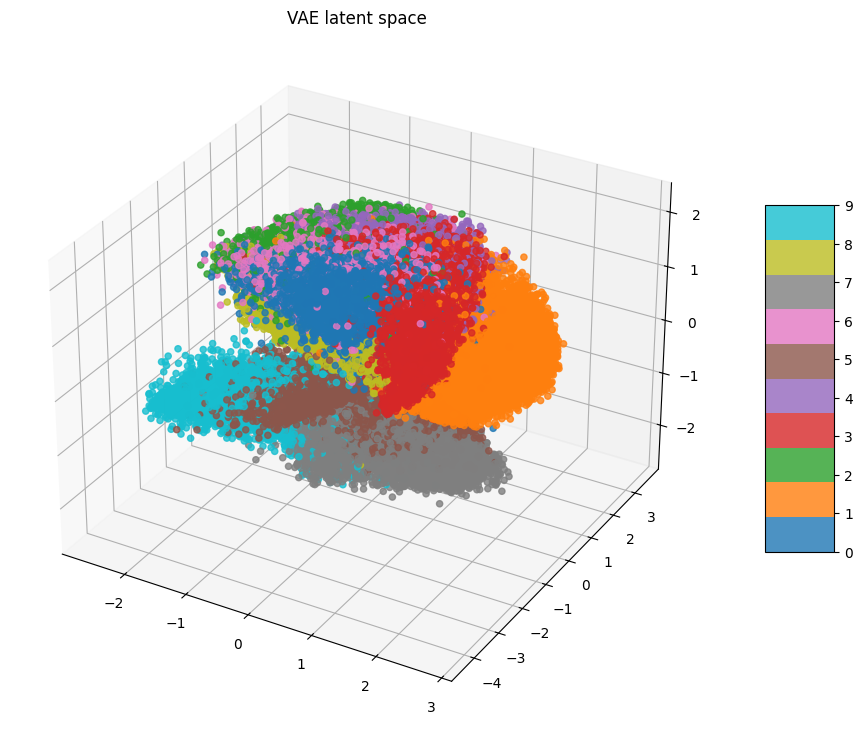

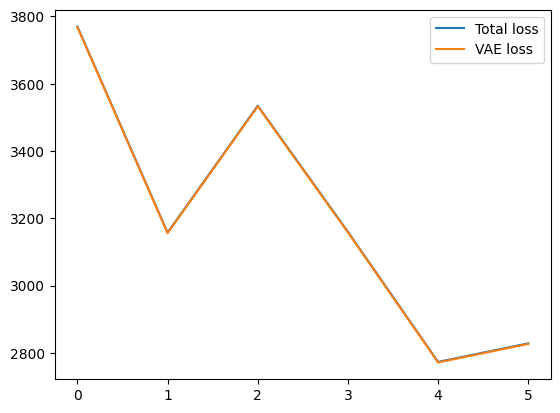

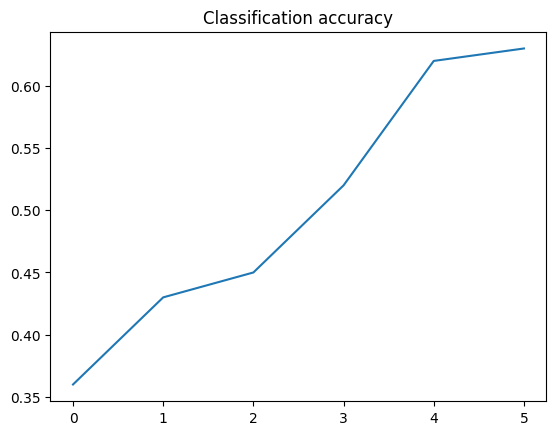

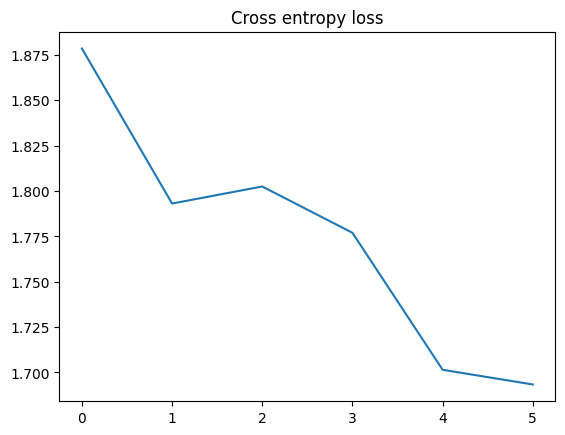

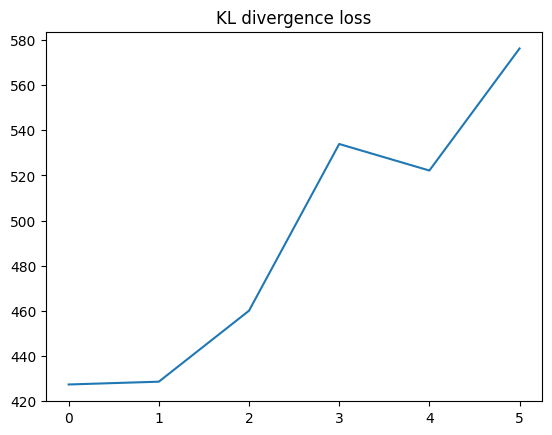

In [6]:
# plot results
plot_vae_classifier_training_result(
    input=input,
    labels=labels,
    vae_model_classifier=vae_classifier_model,
    vae_loss_li=np_vae_loss_li,
    total_losses=total_losses, 
    classifier_accuracy_li=np_classifier_accuracy_li, 
    classifier_loss_li=np_classifier_loss_li,
    kl_loss_li=np_kl_loss_li
)

In [ ]:
# train classifier for performance evaluation
classifier = CIFAR10Classifier()
if cuda.is_available():
    classifier.cuda()

classifier.train_model(training_data, batch_size=32, learning_rate=0.01, epochs=20)
accuracy = classifier.test_model(testing_data)
print("Test accuracy: ", accuracy)

Epoch done:  1


In [11]:
# test quality of images
x, y = vae.generate_data(n_samples=10000)

assert x.shape[0] == y.shape[0]
print("Number of images: ", x.shape[0])

accuracy = classifier.test_model_syn_img_label(x, y)
print("Accuracy: ", accuracy)

Number of images:  10000
Accuracy:  0.5964


In [10]:
# # Determine FID
# # generate 500 images
# syn_input, _ = vae.generate_data(n_samples=500)
# input = input[:500]
# 
# input_rgb = input.view(-1, 1, 28, 28).repeat(1, 3, 1, 1)
# syn_input_rgb = syn_input.view(-1, 1, 28, 28).repeat(1, 3, 1, 1)
# 
# # compute FID score
# fid_score = frechet_inception_distance(input_rgb, syn_input_rgb)
# print("Frechet Inception Distance: ", fid_score)

KeyboardInterrupt: 